# 50.039 Theory and Practice of Deep Learning Project 2024

Group 10
- Issac Jose Ignatius (1004999)
- Mahima Sharma (1006106)
- Dian Maisara (1006377)


### Import all relevant libraries

In [1]:
# Numpy
import numpy as np
# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Torchvision
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode

from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix

import math
from tqdm.notebook import tqdm

# File Operations
import os

import sys
sys.path.insert(0, '../utils')
from models import ConvNet, SkipNet, ResNet
from helpers import load_model, detach_tensor

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") 
print(device)

cuda


In [3]:
DATA_PATH = os.path.join(os.path.abspath(''), "../ChexPhoto/chexphoto-v1")
print(DATA_PATH)

c:\Users\User\Desktop\50.039 TPDL\2024_TPDL\notebooks\../ChexPhoto/chexphoto-v1


### Load in Labels 

In [4]:
# Bug in Path present in training dataset
def fix_error_paths(row):
    row = row.replace("//", "/")
    return row

def str_to_array(row):
    ndarray = np.fromstring(
                row.replace('\n','')
                    .replace('[','')
                    .replace(']','')
                    .replace('  ',' '), 
                    sep=' ')
    return ndarray

In [5]:
labels = ['Pleural Effusion', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Edema', 'Pleural Other', 'Fracture', 'Support Devices']

test_df = pd.read_csv("../data/processed/test_one_hot_encoded.csv", index_col=False)
test_df["Path"] = test_df["Path"].apply(fix_error_paths)

for label in labels:
    test_df[label] = test_df[label].apply(str_to_array)

display(test_df)

,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,test/patient64741/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
1,test/patient64742/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2,test/patient64743/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
3,test/patient64744/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
4,test/patient64744/study1/view2_lateral.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,test/patient65236/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
664,test/patient65237/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
665,test/patient65238/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
666,test/patient65239/study1/view1_frontal.jpg,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"


In [6]:
def keep_observations(df, cols):
    return df[cols].copy()

In [7]:
# Drop all other labels
cols = ["Path", "Pleural Effusion", "Cardiomegaly"]
df_test = keep_observations(test_df, cols)

In [8]:
def ohe_to_class(row):
    if np.sum(row) > 0:
        return np.argmax(row)
    else:
        return -100

df_test["Class_pEff"] = df_test["Pleural Effusion"].apply(ohe_to_class)
df_test["Class_cardio"] = df_test["Cardiomegaly"].apply(ohe_to_class)

In [9]:
display(df_test)

,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio
0,test/patient64741/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
1,test/patient64742/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
2,test/patient64743/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
3,test/patient64744/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
4,test/patient64744/study1/view2_lateral.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
...,...,...,...,...,...
663,test/patient65236/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
664,test/patient65237/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
665,test/patient65238/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
666,test/patient65239/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2


In [10]:
def sum_array(row):
    return np.sum(row)

df_test["Pleural Effusion_sum"] = df_test["Pleural Effusion"].apply(sum_array)
df_test["Cardiomegaly_sum"] = df_test["Cardiomegaly"].apply(sum_array)

display(df_test)

,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio,Pleural Effusion_sum,Cardiomegaly_sum
0,test/patient64741/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2,1.0,1.0
1,test/patient64742/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1,1.0,1.0
2,test/patient64743/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2,1.0,1.0
3,test/patient64744/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1,1.0,1.0
4,test/patient64744/study1/view2_lateral.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1,1.0,1.0
...,...,...,...,...,...,...,...
663,test/patient65236/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2,1.0,1.0
664,test/patient65237/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1,1.0,1.0
665,test/patient65238/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1,1.0,1.0
666,test/patient65239/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2,1.0,1.0


In [11]:
df_test = df_test[(df_test["Pleural Effusion_sum"] > 0) | (df_test["Cardiomegaly_sum"] > 0)]

# filter out NaNs in both columns given that we feed class labels to CrossEntropyLoss
cols = ["Path", "Pleural Effusion", "Cardiomegaly", "Class_pEff", "Class_cardio"]
df_train = df_test[cols]
display(df_train)

,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio
0,test/patient64741/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
1,test/patient64742/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
2,test/patient64743/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
3,test/patient64744/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
4,test/patient64744/study1/view2_lateral.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
...,...,...,...,...,...
663,test/patient65236/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
664,test/patient65237/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
665,test/patient65238/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
666,test/patient65239/study1/view1_frontal.jpg,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2


### Custom Dataset implementation

In [12]:
# Implementation of Custom Dataset Class for CheXPhoto Dataset
class CheXDataset(Dataset):
    def __init__(self, df: pd.DataFrame, px_size: int = 256):
        self.dataframe = df.copy()
        self.px_size = px_size
        self.transform = T.Compose([
            v2.Resize((self.px_size, self.px_size), interpolation=T.InterpolationMode.BICUBIC)
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_path = DATA_PATH + "/" + self.dataframe.iloc[idx, 0].split("CheXphoto-v1.0", 1)[-1]
        
        resized_x_tensor = self.transform(read_image(x_path, mode = ImageReadMode.RGB)) /255

        y_pEff, y_cardio = torch.tensor(self.dataframe.iloc[idx, 3]).type(torch.LongTensor), torch.tensor(self.dataframe.iloc[idx, 4]).type(torch.LongTensor)
        return resized_x_tensor, y_pEff, y_cardio

### Custom Dataloader

In [13]:
# Load into custom Dataset
test_data = CheXDataset(df_test)

# Load into DataLoader
batch_size = 128
test_loader = DataLoader(test_data, batch_size)

In [14]:
x, y1, y2 = test_data[0]
print(x, x.shape, x.dtype)
print(y1, y1.shape, y1.dtype)
print(y2, y2.shape, y2.dtype)

tensor([[[0.0275, 0.0314, 0.0235,  ..., 0.0314, 0.0314, 0.0314],
         [0.0157, 0.0235, 0.0118,  ..., 0.0314, 0.0314, 0.0314],
         [0.0118, 0.0235, 0.0235,  ..., 0.0196, 0.0314, 0.0314],
         ...,
         [0.0824, 0.1176, 0.1961,  ..., 0.2314, 0.1569, 0.2588],
         [0.0824, 0.1294, 0.2078,  ..., 0.2314, 0.1686, 0.2784],
         [0.0824, 0.1451, 0.2196,  ..., 0.2392, 0.1725, 0.2471]],

        [[0.0275, 0.0314, 0.0235,  ..., 0.0314, 0.0314, 0.0314],
         [0.0157, 0.0235, 0.0118,  ..., 0.0314, 0.0314, 0.0314],
         [0.0118, 0.0235, 0.0235,  ..., 0.0196, 0.0314, 0.0314],
         ...,
         [0.0824, 0.1176, 0.1961,  ..., 0.2314, 0.1569, 0.2588],
         [0.0824, 0.1294, 0.2078,  ..., 0.2314, 0.1686, 0.2784],
         [0.0824, 0.1451, 0.2196,  ..., 0.2392, 0.1725, 0.2471]],

        [[0.0275, 0.0314, 0.0235,  ..., 0.0314, 0.0314, 0.0314],
         [0.0157, 0.0235, 0.0118,  ..., 0.0314, 0.0314, 0.0314],
         [0.0118, 0.0235, 0.0235,  ..., 0.0196, 0.0314, 0.

In [15]:
def test_loop(model, test_loader):
    model.eval()

    f1_pEff = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)
    precision_pEff = MulticlassPrecision(num_classes=3, ignore_index=-100).to(device)
    recall_pEff = MulticlassRecall(num_classes=3, ignore_index=-100).to(device)
    confusion_matrix_pEff = MulticlassConfusionMatrix(num_classes=3, ignore_index=-100).to(device)

    f1_cardio = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)
    precision_cardio = MulticlassPrecision(num_classes=3, ignore_index=-100).to(device)
    recall_cardio = MulticlassRecall(num_classes=3, ignore_index=-100).to(device)
    confusion_matrix_cardio = MulticlassConfusionMatrix(num_classes=3, ignore_index=-100).to(device)

    with torch.no_grad():
        for inputs, outputs_pEff, outputs_cardio in tqdm(test_loader):
            inputs_re, outputs_re_pEff, outputs_re_cardio = inputs.to(device), outputs_pEff.to(device), outputs_cardio.to(device)
            preds = model(inputs_re)

            f1_pEff.update(preds[0], outputs_re_pEff)
            precision_pEff.update(preds[0], outputs_re_pEff)
            recall_pEff.update(preds[0], outputs_re_pEff)
            confusion_matrix_pEff.update(preds[0], outputs_re_pEff)

            f1_cardio.update(preds[1], outputs_re_cardio)
            precision_cardio.update(preds[1], outputs_re_cardio)
            recall_cardio.update(preds[1], outputs_re_cardio)
            confusion_matrix_cardio.update(preds[1], outputs_re_cardio)

    test_f1_pEff = f1_pEff.compute()
    test_precision_pEff = precision_pEff.compute()
    test_recall_pEff = recall_pEff.compute()
    test_confusion_matrix_pEff = confusion_matrix_pEff.compute()

    test_f1_cardio = f1_cardio.compute()
    test_precision_cardio = precision_cardio.compute()
    test_recall_cardio = recall_cardio.compute()
    test_confusion_matrix_cardio = confusion_matrix_cardio.compute()

    print(f'--- Pleural Effusion - Test F1: {test_f1_pEff:.4f}, Test Precision: {test_precision_pEff:.4f}, Test Recall: {test_recall_pEff:.4f}')
    print(f'--- Test Confusion Matrix: \n{test_confusion_matrix_pEff}\n')

    print(f'--- Cardiomegaly - Test F1: {test_f1_cardio:.4f}, Test Precision: {test_precision_cardio:.4f}, Test Recall: {test_recall_cardio:.4f}')
    print(f'--- Test Confusion Matrix: \n{test_confusion_matrix_cardio}\n')

    return test_f1_pEff, test_precision_pEff, test_recall_pEff, test_confusion_matrix_pEff, test_f1_cardio, test_precision_cardio, test_recall_cardio, test_confusion_matrix_cardio

## Evaluation

### Full Dataset Training

#### ConvNet

In [16]:
model_convnet = load_model(ConvNet, "convnet", 3, path="../models").to(device)
print(model_convnet)

ConvNet(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [17]:
conv_full = test_loop(model_convnet, test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Pleural Effusion - Test F1: 0.5201, Test Precision: 0.6297, Test Recall: 0.7050
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 243, 305],
        [  0,   4, 116]], device='cuda:0')

--- Cardiomegaly - Test F1: 0.5640, Test Precision: 0.6677, Test Recall: 0.6911
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 211, 282],
        [  0,   8, 167]], device='cuda:0')



In [18]:
print(conv_full)

(tensor(0.5201, device='cuda:0'), tensor(0.6297, device='cuda:0'), tensor(0.7050, device='cuda:0'), tensor([[  0,   0,   0],
        [  0, 243, 305],
        [  0,   4, 116]], device='cuda:0'), tensor(0.5640, device='cuda:0'), tensor(0.6677, device='cuda:0'), tensor(0.6911, device='cuda:0'), tensor([[  0,   0,   0],
        [  0, 211, 282],
        [  0,   8, 167]], device='cuda:0'))


#### SkipNet

In [19]:
model_skipnet = load_model(SkipNet, "skipnet", 1, path="../models").to(device)
print(model_skipnet)

SkipNet(
  (skip_layers): Sequential(
    (0): SkipBlock(
      (conv1): ConvolutionBlock(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv2): ConvolutionBlock(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (skip_connection): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
        (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
      )
    )
    (1): SkipBlock(
      (conv1): ConvolutionBlock(
        (conv): Conv2d(16

In [20]:
skip_full = test_loop(model_skipnet, test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Pleural Effusion - Test F1: 0.5910, Test Precision: 0.6370, Test Recall: 0.7323
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 314, 234],
        [  0,  13, 107]], device='cuda:0')

--- Cardiomegaly - Test F1: 0.7269, Test Precision: 0.7161, Test Recall: 0.7543
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 386, 107],
        [  0,  48, 127]], device='cuda:0')



#### ResNet

In [21]:
model_resnet = load_model(ResNet, "resnet", 4, path="../models").to(device)
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [22]:
res_full = test_loop(model_resnet, test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Pleural Effusion - Test F1: 0.6352, Test Precision: 0.6598, Test Recall: 0.7699
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 346, 202],
        [  0,  11, 109]], device='cuda:0')

--- Cardiomegaly - Test F1: 0.7286, Test Precision: 0.7273, Test Recall: 0.7298
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 421,  72],
        [  0,  69, 106]], device='cuda:0')



### Random Sampling

#### ConvNet

In [23]:
model_convnet = load_model(ConvNet, "convnet", 22, path="../models-2").to(device)
print(model_convnet)

ConvNet(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [24]:
conv_sampling = test_loop(model_convnet, test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Pleural Effusion - Test F1: 0.6414, Test Precision: 0.6541, Test Recall: 0.7562
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 363, 185],
        [  0,  18, 102]], device='cuda:0')

--- Cardiomegaly - Test F1: 0.5565, Test Precision: 0.6604, Test Recall: 0.6824
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 208, 285],
        [  0,  10, 165]], device='cuda:0')



#### SkipNet

In [25]:
model_skipnet = load_model(SkipNet, "skipnet", 12, path="../models-2").to(device)
print(model_skipnet)

SkipNet(
  (skip_layers): Sequential(
    (0): SkipBlock(
      (conv1): ConvolutionBlock(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv2): ConvolutionBlock(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (skip_connection): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
        (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
      )
    )
    (1): SkipBlock(
      (conv1): ConvolutionBlock(
        (conv): Conv2d(16

In [26]:
skip_sampling = test_loop(model_skipnet, test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Pleural Effusion - Test F1: 0.5975, Test Precision: 0.6383, Test Recall: 0.7345
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 321, 227],
        [  0,  14, 106]], device='cuda:0')

--- Cardiomegaly - Test F1: 0.6188, Test Precision: 0.6690, Test Recall: 0.7135
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 264, 229],
        [  0,  19, 156]], device='cuda:0')



#### ResNet

In [27]:
model_resnet = load_model(ResNet, "resnet", 28, path="../models-2").to(device)
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [28]:
res_sampling = test_loop(model_resnet, test_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

--- Pleural Effusion - Test F1: 0.7062, Test Precision: 0.6885, Test Recall: 0.7757
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 430, 118],
        [  0,  28,  92]], device='cuda:0')

--- Cardiomegaly - Test F1: 0.6324, Test Precision: 0.6670, Test Recall: 0.7146
--- Test Confusion Matrix: 
tensor([[  0,   0,   0],
        [  0, 282, 211],
        [  0,  25, 150]], device='cuda:0')



In [29]:
results = [conv_full, conv_sampling, skip_full, skip_sampling, res_full, res_sampling]

results_df = pd.DataFrame(results, columns=["F1_pEff", "Precision_pEff", "Recall_pEff", "Confusion_Matrix_pEff", "F1_cardio", "Precision_cardio", "Recall_cardio", "Confusion_Matrix_cardio"], index=["ConvNet_Full", "ConvNet_Sampling", "SkipNet_Full", "SkipNet_Sampling", "ResNet_Full", "ResNet_Sampling"])
display(results_df)

,F1_pEff,Precision_pEff,Recall_pEff,Confusion_Matrix_pEff,F1_cardio,Precision_cardio,Recall_cardio,Confusion_Matrix_cardio
ConvNet_Full,"tensor(0.5201, device='cuda:0')","tensor(0.6297, device='cuda:0')","tensor(0.7050, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device...","tensor(0.5640, device='cuda:0')","tensor(0.6677, device='cuda:0')","tensor(0.6911, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
ConvNet_Sampling,"tensor(0.6414, device='cuda:0')","tensor(0.6541, device='cuda:0')","tensor(0.7562, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device...","tensor(0.5565, device='cuda:0')","tensor(0.6604, device='cuda:0')","tensor(0.6824, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
SkipNet_Full,"tensor(0.5910, device='cuda:0')","tensor(0.6370, device='cuda:0')","tensor(0.7323, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device...","tensor(0.7269, device='cuda:0')","tensor(0.7161, device='cuda:0')","tensor(0.7543, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
SkipNet_Sampling,"tensor(0.5975, device='cuda:0')","tensor(0.6383, device='cuda:0')","tensor(0.7345, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device...","tensor(0.6188, device='cuda:0')","tensor(0.6690, device='cuda:0')","tensor(0.7135, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
ResNet_Full,"tensor(0.6352, device='cuda:0')","tensor(0.6598, device='cuda:0')","tensor(0.7699, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device...","tensor(0.7286, device='cuda:0')","tensor(0.7273, device='cuda:0')","tensor(0.7298, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."
ResNet_Sampling,"tensor(0.7062, device='cuda:0')","tensor(0.6885, device='cuda:0')","tensor(0.7757, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device...","tensor(0.6324, device='cuda:0')","tensor(0.6670, device='cuda:0')","tensor(0.7146, device='cuda:0')","[[tensor(0, device='cuda:0'), tensor(0, device..."


In [30]:
results_df.drop(columns=["Confusion_Matrix_pEff", "Confusion_Matrix_cardio"], inplace=True)
display(results_df)

,F1_pEff,Precision_pEff,Recall_pEff,F1_cardio,Precision_cardio,Recall_cardio
ConvNet_Full,"tensor(0.5201, device='cuda:0')","tensor(0.6297, device='cuda:0')","tensor(0.7050, device='cuda:0')","tensor(0.5640, device='cuda:0')","tensor(0.6677, device='cuda:0')","tensor(0.6911, device='cuda:0')"
ConvNet_Sampling,"tensor(0.6414, device='cuda:0')","tensor(0.6541, device='cuda:0')","tensor(0.7562, device='cuda:0')","tensor(0.5565, device='cuda:0')","tensor(0.6604, device='cuda:0')","tensor(0.6824, device='cuda:0')"
SkipNet_Full,"tensor(0.5910, device='cuda:0')","tensor(0.6370, device='cuda:0')","tensor(0.7323, device='cuda:0')","tensor(0.7269, device='cuda:0')","tensor(0.7161, device='cuda:0')","tensor(0.7543, device='cuda:0')"
SkipNet_Sampling,"tensor(0.5975, device='cuda:0')","tensor(0.6383, device='cuda:0')","tensor(0.7345, device='cuda:0')","tensor(0.6188, device='cuda:0')","tensor(0.6690, device='cuda:0')","tensor(0.7135, device='cuda:0')"
ResNet_Full,"tensor(0.6352, device='cuda:0')","tensor(0.6598, device='cuda:0')","tensor(0.7699, device='cuda:0')","tensor(0.7286, device='cuda:0')","tensor(0.7273, device='cuda:0')","tensor(0.7298, device='cuda:0')"
ResNet_Sampling,"tensor(0.7062, device='cuda:0')","tensor(0.6885, device='cuda:0')","tensor(0.7757, device='cuda:0')","tensor(0.6324, device='cuda:0')","tensor(0.6670, device='cuda:0')","tensor(0.7146, device='cuda:0')"


In [31]:
for col in results_df.columns.to_list():
    results_df[col] = results_df[col].apply(detach_tensor)

display(results_df)

,F1_pEff,Precision_pEff,Recall_pEff,F1_cardio,Precision_cardio,Recall_cardio
ConvNet_Full,0.520078,0.629670,0.705049,0.563977,0.667704,0.691139
ConvNet_Sampling,0.641357,0.654078,0.756204,0.556546,0.660398,0.682382
SkipNet_Full,0.590961,0.637014,0.732330,0.726910,0.716068,0.754338
SkipNet_Sampling,0.597529,0.638264,0.734550,0.618778,0.669029,0.713463
ResNet_Full,0.635221,0.659835,0.769860,0.728564,0.727345,0.729835
ResNet_Sampling,0.706223,0.688480,0.775669,0.632351,0.667040,0.714576


In [32]:
results_df["F1_combined"] = (results_df["F1_pEff"] + results_df["F1_cardio"]) / 2
display(results_df)

,F1_pEff,Precision_pEff,Recall_pEff,F1_cardio,Precision_cardio,Recall_cardio,F1_combined
ConvNet_Full,0.520078,0.629670,0.705049,0.563977,0.667704,0.691139,0.542027
ConvNet_Sampling,0.641357,0.654078,0.756204,0.556546,0.660398,0.682382,0.598951
SkipNet_Full,0.590961,0.637014,0.732330,0.726910,0.716068,0.754338,0.658936
SkipNet_Sampling,0.597529,0.638264,0.734550,0.618778,0.669029,0.713463,0.608153
ResNet_Full,0.635221,0.659835,0.769860,0.728564,0.727345,0.729835,0.681892
ResNet_Sampling,0.706223,0.688480,0.775669,0.632351,0.667040,0.714576,0.669287


#### Visualisation

In [33]:
import matplotlib.pyplot as plt

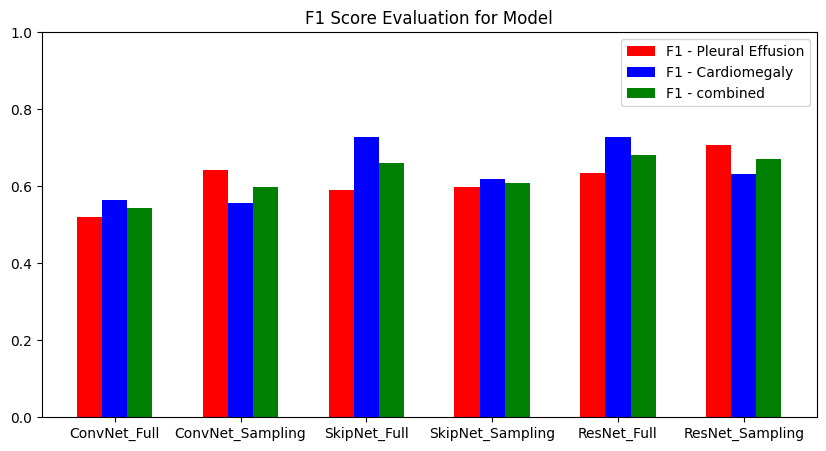

In [44]:
ind = np.arange(len(results_df))
width = 0.2
plt.figure(figsize=(10, 5))
bar1 = plt.bar(ind - width, results_df["F1_pEff"], width, label="F1 - Pleural Effusion", color='r')
bar2 = plt.bar(ind, results_df["F1_cardio"], width, label="F1 - Cardiomegaly", color='b')
bar3 = plt.bar(ind + width, results_df["F1_combined"], width, label="F1 - combined", color='g')
plt.title("F1 Score Evaluation for Model")
plt.xticks(ind, results_df.index.to_list())
plt.ylim((0,1))
plt.legend()